# Memristor Weight Mapping Code
### By Michael Elimu - LY2016030

Import of the necessary Python files required

In [1]:
import numpy as np
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import h5py
from time import perf_counter as my_timer

c:\program files\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Conductance
We need to find the conductance values of the Ron and Roff Resistance values of the memristor
These are necessary, since our weight mappings are entirely based on the usuable conductance range of the memristor element that we shall be using

In [2]:
def conductanceValues(on, off):
    
    Cmax, Cmin = (1/on, 1/off)
    cond_range = Cmax - Cmin
    
    return Cmax, Cmin, cond_range

## Weight and Bias Splits
Seperate the weights to help handle the positive and negative weights and biases differently
This is necessary because, we can not litterally write negative weights to the memristors and we don't want to ignore them as either. 
It is therefore ideal to split them up but however get the absolute values of the negative weights and treat them as positive weights while writing to the memristor. However, during manipulation, the kernel output from the negative weights and bias section can be passed through a substractor together with the corresponding output kernel of the positive weights. This therefore gives us the differnce value that can be fed to the next layers in the neural network
We also desire to obtain a maximum absolute value of either the weights or biases that can be used as the maximum value to be fit in the conductance raange of the memristor. This will help accommodate all the existing values for both the weights and the biases


In [3]:
def weight_split(w_rows, w_cols, w_b_T, mode):

    # Obtain the absolute value of the stacked array
    w_b = np.abs(w_b_T)

    # Get the index of the maximum value
    max_index = w_b.argmax()

    # Retrieve the maximum value
    max_val = w_b.ravel()[max_index]

    w_r, w_c = w_b_T.shape

    w_pos =np.zeros([w_r,w_cols]).reshape(w_r, w_cols)
    w_neg = np.zeros([w_r,w_cols]).reshape(w_r, w_cols)

    w_pos[w_b_T > 0] = w_b_T[w_b_T > 0]
    w_neg[w_b_T <= 0] = w_b_T[w_b_T <= 0]*-1

    W = np.hstack((w_pos, w_neg))
    
    
    if mode == 'proposed':
        P = []
        for i in range(0, w_c, 2):
            if(i+1<w_c):
                P.append(w_pos[:,i])
                P.append(w_pos[:,i+1])

                P.append(w_neg[:,i])
                P.append(w_neg[:,i+1])
           
        W = np.array(P)
        W = W.T

    # print(f"Positive Weights\n{W[:w_rows,:w_cols]}\n")
    # print(f"Negative Weights\n{W[:w_rows,w_cols:]}")
    # print(f"Positive Bias\n{W[w_rows:,:w_cols]}\n")
    # print(f"Negative Bias\n{W[w_rows:,w_cols:]}")
    # assert w_pos.shape == w_b_T.shape
    
    return W, max_val

## Weights and Bias Conductance
We use the previously calculated minimum, maximum conductances and conductance range in the calculation of the weight and bias conductance equivalence in relation to the memristor conductance
### Note:
The weights and biases have been put up together to help ease the manipulation of the whole learned parameters as a crossbar - a reflection of the operation used in memristor crossbar array

In [4]:
def weight_bias_cond(w, cond_range, Cmin, w_b_max):
    
    w_cond = (w/w_b_max)*cond_range + Cmin
    
    return w_cond

In [5]:
def adjust_con_weights(weighted_bits, cond_split):
    
    # Move the weight values to the conductance levels
    r, c = weighted_bits.shape
    for i in range(r):
        for j in range(c):
            for k in range(len(cond_split)):
                weighted_bits[i, j] = cond_split[np.argmax(cond_split>=weighted_bits[i, j] )]
                
#     for con_val in cond_split:
#         if weighted_bits < con_val:
#             weighted_bits = con_val
#             break    
    
    return weighted_bits

## Redundunt Rows and Columns
The main objective of the research is to identify a fault toleranct architecture to the reknown unrecoverable faults called "Stack-at" faults mostly caused by open and closed defects in the memristor crossbar due to manufacture imaturity that exixst for this new technology
We therefore need to simulate some of these faults i.e. stack-at-0 and stack-at-1 faults abbrevaited as SA0 and SA1 respectively.
To help overconme this problem, there are two scenarios that will be considered concurrently
1. If the positive side of the crossbar is faulty but the correspondiing negative cell is not faulty, we can use this to overcome the positive cell fault
2. If the negative side of the crossbar is faulty but the correspondiing positive cell is not faulty, we can use this to overcome the negative cell fault
3. If both the positive and the corresponding negative cells are faulty, we would need to use the redundant rows and columns that are provided in the crossbar array.
Note: The random faults will be applied inclusive of the exixting redandunt cells introduced in the crossbar array, since they may be defected too

In [6]:
def add_red_array(w, per_def, cond_min, mode):
    
    # Expand the array to include fault tolerant cells
    w_row, w_col = w.shape
    cols = 0
    
    # Percentage of rows and columns to add
    rows = int(np.ceil((per_def/100)*w_row))
    
    if mode =='normal':
        cols = int(np.ceil((per_def/100)*w_col))

        if cols%2 != 0:
            cols = cols+1
    
        red_cols = np.zeros((w_row, cols))+cond_min

        w2 = np.concatenate((w, red_cols), axis=1)

        red_rows = np.zeros((rows, w2.shape[1]))+cond_min

        crossbar = np.concatenate((w2, red_rows), axis=0)
    
    if mode == 'proposed':
        P = []
        red_cols = np.zeros((w_row, 1))+cond_min
        
        for j in np.arange(0, w_col, 1):
            if j%4 == 0 and j !=0:
                P.append(red_cols[:, 0])
                P.append(w[:, j])
            else:
                P.append(w[:, j])

        P.append(red_cols[:, 0])
        
        P = np.array(P)
        crossbar = P.T

    return crossbar

### Modified Weight Split

In [7]:
def groupings(cells):
    step = 0
    xbr_pos = []
    xbr_neg = []
    xbr_red = []
    groupings = []
    split_factor = 4
        
    for i in cells:
        if i[1]%5 == 0:
            # groupings.append([i, (i[0], i[1]+2), (i[0], i[1]+1), (i[0], i[1]+3), (i[0], i[1]+split_factor)])
            groupings.append([i, (i[0], i[1]+2), (i[0], i[1]+split_factor)])
            groupings.append([(i[0], i[1]+1), (i[0], i[1]+3), (i[0], i[1]+split_factor)])
            xbr_pos.append(i)
            xbr_pos.append((i[0], i[1]+1))
            xbr_neg.append((i[0], i[1]+2))
            xbr_neg.append((i[0], i[1]+3))
            xbr_red.append((i[0], i[1]+split_factor))
            
    return xbr_pos, xbr_neg, xbr_red, groupings

## Adding The SAFs
This section adds the defects randomly to the crossbar. We need to add these defects inclusive of the redundant rows and columns that we added for overcoming these faults too.
This is because, these cells too are likely to suffer from these defects and we do not have to treat them as a special case. Introducing faults to them renders some cells also not usuable, which is an ideal case

In [8]:
def add_defects(cxbar, perc_def, c_min, c_max):
    f_xbar = np.array(cxbar)
    random.seed(200)
    r, c = cxbar.shape
    all_cells = []
    for i in range(r):
        for j in range(c):
            all_cells.append((i, j))
    # print(all_cells)

##################################################################################################
    # Using Seed to Generate same sequence of cells
    rows = []
    cols = []
    for _ in range(r*c):
        rows.append(random.randint(0, r-1))
        cols.append(random.randint(0, c-1))
###################################################################################################   
    cells = random.choices(all_cells, k=len(all_cells))
    
    
    ###### my_cells = set(cells)
    
    cells_to_change = int((perc_def/100)*(r*c))
    
    # Choose from all_cells randomly
    
    faulty_cells = remove_duplicates(cells, cells_to_change)
    

###############################################################################################    
    # faulty_cells = []
    
    # for i in range(cells_to_change):
        # faulty_cells.append((rows[i], cols[i]))
###############################################################################################
    
    # Assign SA0 and SA1 randomly to the randomly chosen cells
    
    # for i in faulty_cells:
    #     cxbar[i] = random.choice([c_min, c_max])
    faulty_cells = list(faulty_cells)
    
    N = len(faulty_cells)
    for i in range(N//2):
        f_xbar[faulty_cells[i][0],faulty_cells[i][1]] = c_min
    for j in range(N//2, N):
        f_xbar[faulty_cells[j][0],faulty_cells[j][1]] = c_max
        
    # Fault Distribution
    SA0 = []
    SA1 = []

    for i in faulty_cells:
        if cxbar[i] == c_min:
            if i not in SA0:
                SA0.append(i)
        else:
            if i not in SA1:
                SA1.append(i)
      
    # Fault Distibution
    
    # if perc_def == 0:
        # print(f'Fault Distribution\n{"#"*40}\nSA1 - Fault: {perc_def}%\nSA0 - Fault: {perc_def}%\n')
    # else:
        # print(f'Fault Distribution\n{"#"*40}\nSA1 - Fault: {(len(SA1)/ len(faulty_cells))*100}%\nSA0 - Fault: {(len(SA0)/ len(faulty_cells))*100}%\n')
    
    return f_xbar, faulty_cells, all_cells, SA0, SA1


def remove_duplicates(choosen_cells, cells_number):
    f_cells = set()
    
    for cell in choosen_cells:
        if cell not in f_cells:
            yield(cell)
            if len(f_cells)!=cells_number:
                f_cells.add(cell)
            else:
                break
    return f_cells

## Defect Distribution Analysis
A plot of the defect distribution in the crossbar array

Considerations should however be made on the structure of the crossbar array, for simplicity, the positive weighted values have been put to a blue crossbar, while the negative weighted values have been put to yellow crossbars.
Black crossbars are used as the redundant rows and columns

    The green cells indicate cells which do not have faults in them
    Red cells are those that have been affected

In [9]:
def xbr_visualization(xbar, aff_cells, all_xbar_cells, or_xbar_cols, or_xbar_rows,  sa0, sa1, c_min, mod_pos, mod_neg, mode):
    
    r, c = xbar.shape
    # print(f'rows = {r}\nColumns = {c}')
    
    xbar_cells = np.array(all_xbar_cells)
    faulty_ones = np.array(aff_cells)
    
    
    # Distinguish positive and Negative crossbars
    pos_xbr = []
    rec = []
    neg_xbr = []
    for x in all_xbar_cells:
        if xbar[x] == c_min:
            rec.append(x)
            
        if x[1] < or_xbar_cols and x[0]<or_xbar_rows:
            pos_xbr.append(np.array(x))

        if or_xbar_cols <= x[1] < (or_xbar_cols*2)  and x[0]<or_xbar_rows:
            neg_xbr.append(np.array(x))    
 
  
    if mode == 'normal':
        pos__xbr = np.array(pos_xbr)
        neg__xbr = np.array(neg_xbr)
    
    if mode == 'proposed':
        pos__xbr = np.array(mod_pos)
        neg__xbr = np.array(mod_neg)
        
    rec = np.array(rec)
    
    # Demacate SA0 and SA1 Faults
    SA0 = np.array(sa0)
    SA1 = np.array(sa1)
    
    plt.style.use('dark_background')
    plt.figure(figsize=(50, 20))
    
    mpl.rcParams['grid.color'] = 'brown'
    mpl.rcParams['grid.linestyle'] = 'solid'
    mpl.rcParams['grid.linewidth'] = 0.5

    plt.grid(True)
    plt.scatter(xbar_cells[:,1], xbar_cells[:,0],s = 20, marker='s',c='white', label='Redundant cells' )
    
    plt.scatter(pos__xbr[:,1], pos__xbr[:,0],s = 20, c='green', marker= 's', label='Positive Weight cells' )
    plt.scatter(neg__xbr[:,1], neg__xbr[:,0],s = 20,c='blue', marker= 's', label='Negative Weight cells' )
    plt.scatter(rec[:,1], rec[:,0],s = 20, c='white', marker= 's', label='Available for recovery')
#     plt.scatter(faulty_ones[:,1],faulty_ones[:,0], c='red', marker='o')
    if SA0.size > 0:
        plt.scatter(SA0[:,1],SA0[:,0],s = 20, c='red', marker='s', label='SA0 Weight cells')
    if SA1.size > 0:
        plt.scatter(SA1[:,1],SA1[:,0],s = 20, c='yellow', marker='s', label='SA1 Weight cells')
    
    
    # plt.scatter(usable_cells[:,1], usable_cells[:,0],s = 20, marker= 's', label='Usable cells' )
    
    plt.ylim(r,-1)
    plt.xlim(-1,c)
    
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.1), ncol=3)
    
    return plt.show()

## Fault Handling
Many scenarios will be handled in this section depending on the cell behavior and whether or it it is affected
Both cells in the positive and negative sides of the crossbar array need to be considered, since a fault in one needs to be overcome by the non-faulty cell in the corresponding cell if it is not faulty
#### SA1:
#### SA0:

### Using the Corresponding Rows and Columns

In [10]:
def corr_rows_cols(xbr_f, xbr, SA0, SA1, c, c_min, c_max):
    SA = SA0 + SA1
    need_rc = []
    rc = []
    
    for i in SA:
        # SA0 FAULT HANDLING CRITERIA
        if xbr_f[i]==c_min:
            if i[1] < c:
                if xbr[i] != c_min:
                    if (i[0], i[1]+c) not in SA:
                        xbr_f[i[0],i[1]+c] = c_min
                        rc = [xbr[i], i]
#                     else:
#                         if r_c >=2:
#                             for x in range(int(r_c/2)):
#                                 if (i[0], i[1]+c+(random.choice(x))) not in SA:
#                                     xbr_f[i[0],i[1]+c+x] = xbr[i]
                        
            if c<=i[1] < c*2:
                if xbr[i] != c_min:
                    if (i[0], i[1]-c) not in SA:
                        xbr_f[i[0],i[1]-c] = c_min
                        rc = [xbr[i], i]
#                     else:
#                         if r_c >=2:
#                             for x in range(int(r_c/2), r_c):
#                                 if (i[0], i[1]+c+(random.choice(x))) not in SA:
#                                     xbr_f[i[0],i[1]+c+x] = xbr[i]

            if rc not in need_rc and len(rc) != 0:
                need_rc.append(rc)

        # SA1 FAULT HANDLING CRITERIA
        if xbr_f[i] == c_max:
            if i[1]<c:
                if xbr[i] != c_max:
                    if (i[0], i[1]+c) not in SA:
                        if xbr[i] > c_min: 
                            xbr_f[i[0],i[1]+c] = c_max - xbr[i] + c_min
                else: 
                    xbr_f[i[0],i[1]+c] = c_max
                    rc = [xbr[i], i]
#                     else:
#                         if r_c >=2:
#                             for x in range(int(r_c/2)):
#                                 if (i[0], i[1]+c+(random.choice(x))) not in SA:
#                                     xbr_f[i[0],i[1]+c+(x)] = xbr[i]
                                
                        # TO DO -ELSE IF NOT Greater than 2
            if c<=i[1]<c*2:
                if xbr[i] != c_max:
                    if (i[0], i[1]-c) not in SA:
                        xbr_f[i[0],i[1]-c] = c_max - xbr[i] + c_min
                else: 
                    xbr_f[i[0],i[1]-c] = c_max
                    rc = [xbr[i], i]
    
            if rc not in need_rc and len(rc) != 0:
                need_rc.append(rc)
# WORKING CODE
#     for i in SA:
        
#         # SA0 FAULT HANDLING CRITERIA
#         if xbr_f[i]==c_min:
#             if i[1] < c:
#                 if xbr[i] != c_min:
#                     if (i[0], i[1]+c) not in SA:
#                         xbr_f[i[0],i[1]+c] = c_min
                        
#             if c<=i[1] < c*2:
#                 if xbr[i] != c_min:
#                     if (i[0], i[1]-c) not in SA:
#                         xbr_f[i[0],i[1]-c] = c_min

#         # SA1 FAULT HANDLING CRITERIA
#         if xbr_f[i] == c_max:
#             if i[1]<c:
#                 if xbr[i] != c_max:
#                     if (i[0], i[1]+c) not in SA:
#                         if xbr[i] > c_min: 
#                             xbr_f[i[0],i[1]+c] = c_max - xbr[i] + c_min
#                 else: 
#                     xbr_f[i[0],i[1]+c] = c_max
                                

#             if c<=i[1]<c*2:
#                 if xbr[i] != c_max:
#                     if (i[0], i[1]-c) not in SA:
#                         xbr_f[i[0],i[1]-c] = c_max - xbr[i] + c_min
#                 else: 
#                     xbr_f[i[0],i[1]-c] = c_max
    
    return xbr_f, need_rc

In [11]:
# def corr_rows_cols(xbr_f, xbr, SA0, SA1, c, c_min, c_max, mode='existing_cells'):
#     both_faulty = []
#     faluty_rc = []
#     xbr_cols = xbr_f.shape[1]
#     red_cols = xbr_cols - c*2
#     xbr_or = xbr.shape[1]
#     red_pos = int(red_cols/2)
#     r_c = xbr.shape[1] - (c*2)
#     r_c_rec = ()
#     mappings = []
    
#     SA = SA0 + SA1
    
#     for x in SA:
#     # Identifying Faulty Cells and their corresponding ones
#         for j in SA1 or j in SA0:
#             if x[0] == j[0]:
                
#                 # FAULTY REDUNDANT COLUMNS
#                 if j[1] >= c*2:
#                     faluty_rc.append(j)
                    
#                 # BOTH FAULTY CELLS
#                 if x[1] == j[1]-c or x[1] == j[1]+c or x[1]-c == j[1] or x[1]+c == j[1]:
#                     if [j, x] in both_faulty or [x, j] in both_faulty :
#                         continue
#                     else:
#                         both_faulty.append(x)
#                         both_faulty.append(j)
    
#     for i in SA:
        
#         # SA0 FAULT HANDLING CRITERIA
#         if xbr_f[i]==c_min:
            
#             # Positive Crossbar Side!
#             if i[1] < c:
#                 if xbr[i] != c_min:
#                     if (i[0], i[1]+c) not in SA:
                        
#                         # if mode == 'cells':
#                         xbr_f[i[0],i[1]+c] = c_min
                        
#                         if mode == 'mixed':
#                             r_c = random.choice(np.arange(red_pos))
#                             if (i[0], c*2+r_c) not in SA:
                                
#                                 if (i[0], c*2+r_c+ red_pos) not in SA:

#                                     if xbr_f[i[0],c*2+r_c] < xbr[i]:
#                                         xbr_f[i[0],c*2+r_c] = xbr[i]
#                                         mappings.append((i, r_c))
#                                 else:
#                                     if (i[0], c*2+r_c+ red_pos) in SA_1:
#                                         xbr_f[i[0],c*2+r_c] = c_max
#                                         mappings.append((i, r_c))
                            
#                             if (i[0], c*2+r_c) in SA_1:

#                                 if (i[0], c*2+r_c + red_pos) not in SA:

#                                     if xbr_f[i[0],c*2+r_c+ red_pos] < c_max - xbr[i] + c_min:
#                                         xbr_f[i[0],c*2+r_c+ red_pos] = c_max - xbr[i] + c_min
#                                         mappings.append((i, r_c))
                        
#             # Negative Crossbar Side!            
#             if c<=i[1] < c*2:
#                 if xbr[i] != c_min:
#                     if (i[0], i[1]-c) not in SA:
                        
#                         # if mode == 'cells':
#                         xbr_f[i[0],i[1]-c] = c_min
                        
#                         if mode == 'mixed':
#                             r_c = random.choice(np.arange(red_pos, red_cols))
                            
#                             if (i[0], c*2+r_c) not in SA :
                                
#                                 if (i[0], c*2+r_c-red_pos) not in SA or (i[0], c*2+r_c - red_pos) in SA_0:
                                
#                                     if xbr_f[i[0],c*2+r_c] < xbr[i]:
#                                         xbr_f[i[0],c*2+r_c] = xbr[i]
#                                         mappings.append((i, r_c))
#                                 else:
#                                     if (i[0], c*2+r_c - red_pos) in SA_1:
#                                         xbr_f[i[0],c*2+r_c] = c_max
#                                         mappings.append((i, r_c))
                                        
#                             if (i[0], c*2+r_c) in SA_1:

#                                 if (i[0], c*2+r_c - red_pos) not in SA:
                                    
#                                     xbr_f[i[0], i[1]-c] = c_max - xbr[i] + c_min
#                                     mappings.append((i, r_c))
                    
#                     if (i[0], i[1]-c) in SA_0:
                        
#                         if mode == 'mixed':

#                             if (i[0], c*2+r_c) not in SA:

#                                 if (i[0], c*2+r_c - red_pos) not in SA or (i[0], c*2+r_c - red_pos) in SA_0:

#                                     if xbr_f[i[0],c*2+r_c] < xbr[i]:
#                                         xbr_f[i[0],c*2+r_c] = xbr[i]
#                                         mappings.append((i, r_c))
#                                 else:
#                                     if (i[0], c*2+r_c - red_pos) in SA_1:
#                                         xbr_f[i[0],c*2+r_c] = c_max
#                                         mappings.append((i, r_c))
#                             else:
#                                 if (i[0], c*2+r_c) in SA_1:

#                                     if (i[0], c*2+r_c - red_pos) not in SA:

#                                         if xbr_f[i[0],c*2+r_c - red_pos] < c_max - xbr[i] + c_min:
#                                             xbr_f[i[0],c*2+r_c - red_pos] = c_max - xbr[i] + c_min
#                                             mappings.append((i, r_c))
                            

#                     if (i[0], i[1]-c) in SA_1:
                        
#                         if mode == 'mixed':

#                             if (i[0], c*2+r_c) not in SA:

#                                 if (i[0], c*2+r_c - red_pos) not in SA or (i[0], c*2+r_c - red_pos) in SA_0 or (i[0], c*2+r_c - red_pos) in SA_1:

#                                     xbr_f[i[0],c*2+r_c] = c_max
#                                     mappings.append((i, r_c))
#                             else:
#                                 if (i[0], c*2+r_c) in SA_1:

#                                     if (i[0], c*2+r_c - red_pos) not in SA:

#                                         if xbr_f[i[0],c*2+r_c - red_pos] > c_min:
#                                             xbr_f[i[0],c*2+r_c - red_pos] = c_min
#                                             mappings.append((i, r_c))

#         # SA1 FAULT HANDLING CRITERIA
#         if xbr_f[i] == c_max:
            
#             # Positive Crossbar Side
#             if i[1]<c:
#                 if xbr[i] != c_max:
#                     if (i[0], i[1]+c) not in SA:
#                         if xbr[i] > c_min: 
#                             xbr_f[i[0],i[1]+c] = c_max - xbr[i] + c_min
                            
#                             if mode == 'mixed':
                            
#                                 r_c = random.choice(np.arange(red_pos))

#                                 if (i[0], i[1]+c) in SA_0:

#                                     if (i[0], c*2+r_c) not in SA:

#                                         if (i[0], c*2+r_c+ red_pos) not in SA:

#                                             if xbr_f[i[0], c*2+r_c] < xbr[i]:
#                                                 xbr_f[i[0], c*2+r_c] = xbr[i]
#                                                 mappings.append((i, r_c))

#                                             if xbr_f[i[0],c*2+r_c + red_pos] < c_max:
#                                                 xbr_f[i[0],c*2+r_c+ red_pos] = c_max
#                                                 mappings.append((i, r_c))
#                                         else:
#                                             if (i[0], c*2+r_c+ red_pos) in SA_1:
#                                                 if xbr_f[i[0], c*2+r_c] < xbr[i]:
#                                                     xbr_f[i[0], c*2+r_c] = xbr[i]
#                                                     mappings.append((i, r_c))
#                                     else:
#                                         if (i[0], c*2+r_c) in SA_1:

#                                             if (i[0], c*2+r_c + red_pos) not in SA:

#                                                 if xbr_f[i[0],c*2+r_c+ red_pos] < c_max:
#                                                     xbr_f[i[0],c*2+r_c+ red_pos] = c_max
#                                                     mappings.append((i, r_c))

#                                 if (i[0], i[1]+c) in SA_1:

#                                     if (i[0], c*2+r_c) not in SA:

#                                         if (i[0], c*2+r_c+ red_pos) not in SA:

#                                             if xbr_f[i[0],c*2+r_c] < xbr[i]:
#                                                 xbr_f[i[0],c*2+r_c] = xbr[i]
#                                                 mappings.append((i, r_c))

#                                         if (i[0], c*2+r_c+ red_pos) in SA_1:

#                                             if xbr_f[i[0],c*2+r_c] < c_max:

#                                                 xbr_f[i[0],c*2+r_c] = c_max
#                                                 mappings.append((i, r_c))

#                                     else:
#                                         if (i[0], c*2+r_c) in SA_1:

#                                             if (i[0], c*2+r_c + red_pos) not in SA:

#                                                 if xbr_f[i[0],c*2+r_c+ red_pos] < c_max - xbr[i] + c_min:

#                                                     xbr_f[i[0],c*2+r_c+ red_pos] = c_max - xbr[i] + c_min
#                                                     mappings.append((i, r_c))
                
#                 else: 
#                     xbr_f[i[0],i[1]+c] = c_max
                                
#             # Negative Crossbar Side
#             if c<=i[1]<c*2:
#                 if xbr[i] != c_max:
#                     if (i[0], i[1]-c) not in SA:
#                         xbr_f[i[0],i[1]-c] = c_max - xbr[i] + c_min
                        
#                         if mode == 'mixed':
                            
#                             r_c = random.choice(np.arange(red_pos, red_cols))
                        
#                             if (i[0], i[1]-c) in SA_0:

#                                 if (i[0], c*2+r_c) not in SA:

#                                     if (i[0], c*2+r_c - red_pos) not in SA:

#                                         if xbr_f[i[0],c*2+r_c- red_pos] < c_max - xbr[i] + c_min:
#                                             xbr_f[i[0],c*2+r_c- red_pos] = c_max - xbr[i] + c_min
#                                             mappings.append((i, r_c))
#                                     else:
#                                         if (i[0], c*2+r_c - red_pos) in SA_1:

#                                             if xbr_f[i[0],c*2+r_c] < xbr[i]:

#                                                 xbr_f[i[0],c*2+r_c] = xbr[i]
#                                                 mappings.append((i, r_c))

#                                         if (i[0], c*2+r_c - red_pos) in SA_0:

#                                             if xbr_f[i[0],c*2+r_c] > c_min:
#                                                 xbr_f[i[0],c*2+r_c] = c_min
#                                                 mappings.append((i, r_c))

#                                 else:
#                                     if (i[0], c*2+r_c) in SA_1:

#                                         if (i[0], c*2+r_c - red_pos) not in SA:

#                                             if xbr_f[i[0],c*2+r_c - red_pos] < c_max :
#                                                 xbr_f[i[0],c*2+r_c - red_pos] = c_max
#                                                 mappings.append((i, r_c))

#                                     if (i[0], c*2+r_c) in SA_0:

#                                         if (i[0], c*2+r_c - red_pos) not in SA:

#                                             if xbr_f[i[0],c*2+r_c - red_pos] < c_max - xbr[i] + c_min :
#                                                 xbr_f[i[0],c*2+r_c - red_pos] = c_max - xbr[i] + c_min
#                                                 mappings.append((i, r_c))


#                             if (i[0], i[1]-c) in SA_1:

#                                 if (i[0], c*2+r_c) not in SA:

#                                     if (i[0], c*2+r_c - red_pos) not in SA or (i[0], c*2+r_c - red_pos) in SA_0:

#                                         if xbr_f[i[0],c*2+r_c] < xbr[i]:
#                                             xbr_f[i[0],c*2+r_c] = xbr[i]
#                                             mappings.append((i, r_c))

#                                     if (i[0], c*2+r_c - red_pos) in SA_1:
#                                         if xbr_f[i[0],c*2+r_c] < c_max:
#                                             xbr_f[i[0],c*2+r_c] = c_max
#                                             mappings.append((i, r_c))

#                                 else:
#                                     if (i[0], c*2+r_c) in SA_1:

#                                         if (i[0], c*2+r_c - red_pos) not in SA:
#                                             if xbr_f[i[0], c*2+r_c - red_pos] < cmax - xbr[i] + c_min:
#                                                 xbr_f[i[0],c*2+r_c - red_pos] = cmax - xbr[i] + c_min
#                                                 mappings.append((i, r_c))
                                                
#                 else: 
#                     xbr_f[i[0],i[1]-c] = c_max
                    
# # WORKING CODE
# #     for i in SA:
        
# #         # SA0 FAULT HANDLING CRITERIA
# #         if xbr_f[i]==c_min:
# #             if i[1] < c:
# #                 if xbr[i] != c_min:
# #                     if (i[0], i[1]+c) not in SA:
# #                         xbr_f[i[0],i[1]+c] = c_min
                        
# #             if c<=i[1] < c*2:
# #                 if xbr[i] != c_min:
# #                     if (i[0], i[1]-c) not in SA:
# #                         xbr_f[i[0],i[1]-c] = c_min

# #         # SA1 FAULT HANDLING CRITERIA
# #         if xbr_f[i] == c_max:
# #             if i[1]<c:
# #                 if xbr[i] != c_max:
# #                     if (i[0], i[1]+c) not in SA:
# #                         if xbr[i] > c_min: 
# #                             xbr_f[i[0],i[1]+c] = c_max - xbr[i] + c_min
# #                 else: 
# #                     xbr_f[i[0],i[1]+c] = c_max
                                

# #             if c<=i[1]<c*2:
# #                 if xbr[i] != c_max:
# #                     if (i[0], i[1]-c) not in SA:
# #                         xbr_f[i[0],i[1]-c] = c_max - xbr[i] + c_min
# #                 else: 
# #                     xbr_f[i[0],i[1]-c] = c_max
    
#     return xbr_f, mappings

### Using the Redundant Rows and Columns

In [12]:
def red_rows_cols(xbr_f, xbr, SA_0, SA_1,  c, c_min, c_max):
    
    SA = SA_0 + SA_1
    xbr_cols = xbr_f.shape[1]
    xbr_or = xbr.shape[1]
    red_cols = xbr_cols - c*2
    red_pos = int(red_cols/2)
    random.seed(200)
    mappings = []
    r_c_rec = []
    r_c = 0
    
    # print(f'Faulty Cells\n{SA}')
    
    for i in SA:
        
        # SA0 FAULT HANDLING CRITERIA
        if xbr_f[i]==c_min:
            if i[1] < c:
                if xbr[i] != c_min:
                    r_c = random.choice(np.arange(red_pos))
                    if (i[0], c*2+r_c) not in SA:
                        
                        # Check if the number of redundant columns is greater than 1
                        '''
                        Consider writing a positive value to the crossbar array
                        - if the resultant value on the crossbar is negative,or less than min conductance
                            we set that cell to a min conductance value
                        - if the resultant is positive, and greater than the conducatnce value, set the 
                            memristor value to that value
                        '''                      
                        
                        if xbr_f[i[0],c*2+r_c] < xbr[i]:
                            xbr_f[i[0],c*2+r_c] = xbr[i]
                        
                        else:
                            xbr_f[i[0],c*2+r_c] = xbr_f[i[0],c*2+r_c]


            if c<=i[1] < c*2:
                if xbr[i] != c_min:
                    r_c = random.choice(range(red_pos, red_cols))
                    if (i[0], c*2+r_c) not in SA:
                        if xbr_f[i[0],c*2+r_c] < xbr[i]:
                            xbr_f[i[0],c*2+r_c] = xbr[i]
                        
                        else:
                            xbr_f[i[0],c*2+r_c] = xbr_f[i[0],c*2+r_c]

        # SA1 FAULT HANDLING CRITERIA
        if xbr_f[i] == c_max:
            if i[1] < c:
                if xbr[i] != c_max:
                    r_c = random.choice(np.arange(red_pos))
                    if (i[0], c*2+r_c) not in SA:
                        if xbr_f[i[0],c*2+r_c] < xbr[i]:
                            xbr_f[i[0],c*2+r_c] = xbr[i]
                        else:
                            xbr_f[i[0],c*2+r_c] = xbr_f[i[0],c*2+r_c]


            if c<=i[1] < c*2:
                if xbr[i] != c_max:
                    r_c = random.choice(range(red_pos, red_cols))
                    if (i[0], c*2+r_c) not in SA:
                        if xbr_f[i[0],c*2+r_c] < xbr[i]:
                            xbr_f[i[0],c*2+r_c] = xbr[i]
                        else:
                            xbr_f[i[0],c*2+r_c] = xbr_f[i[0],c*2+r_c]
        
        r_c_rec = [i, r_c]
        mappings.append(r_c_rec)

    return xbr_f, mappings 

### Combined Redundant Rows and Columns and the Corresponding Rows and Columns

In [13]:
def combined(xbr_f, xbr, SA_0, SA_1,  c, c_min, c_max):
    
    SA = SA_0 + SA_1
    xbr_cols = xbr_f.shape[1]
    xbr_or = xbr.shape[1]
    red_cols = xbr_cols - c*2
    red_pos = int(red_cols/2)
    random.seed(200)
    mappings = []
    faluty_rc = []
    both_faulty = []
    r_c_rec = []
    r_c = 0
    
    if len(SA)!=0:
        # print('Checking SA Cells')
    
        # print(f'Faulty Cells\n{SA}')
        for x in SA:
        # Identifying Faulty Cells and their corresponding ones
        
            # for j in SA_1 or j in SA_0:
            for j in SA:
                if x[0] == j[0]:

                    # FAULTY REDUNDANT COLUMNS
                    if j[1] >= c*2:
                        faluty_rc.append(j)

                    # BOTH FAULTY CELLS
                    if x[1] == j[1]-c or x[1] == j[1]+c or x[1]-c == j[1] or x[1]+c == j[1]:
                        if x not in both_faulty and j not in both_faulty:
                            both_faulty.append(x)
                            both_faulty.append(j)
    
        for i in SA:

            # SA0 FAULT HANDLING CRITERIA
            if xbr_f[i]==c_min:
                if i[1] < c:
                    if xbr[i] > c_min:
#                         pass
                    
#                     else:
#                         # or i in both_faulty:
                      
                        r_c = random.choice(np.arange(red_pos))
                        
                        if (i[0], i[1]+c) in SA_0:

                            if (i[0], c*2+r_c) not in SA:

                                if (i[0], c*2+r_c+ red_pos) not in SA:

                                    if xbr_f[i[0],c*2+r_c] < xbr[i]:
                                        xbr_f[i[0],c*2+r_c] = xbr[i]
                                        r_c_rec = [i, r_c]
                                else:
                                    if (i[0], c*2+r_c+ red_pos) in SA_1:
                                        xbr_f[i[0],c*2+r_c] = c_max
                                        r_c_rec = [i, r_c]
                            else:
                                if (i[0], c*2+r_c) in SA_1:

                                    if (i[0], c*2+r_c + red_pos) not in SA:

                                        if xbr_f[i[0],c*2+r_c+ red_pos] < c_max - xbr[i] + c_min:
                                            xbr_f[i[0],c*2+r_c+ red_pos] = c_max - xbr[i] + c_min
                                            r_c_rec = [i, r_c]

                        if (i[0], i[1]+c) in SA_1:

                            if (i[0], c*2+r_c) not in SA:

                                if (i[0], c*2+r_c+ red_pos) not in SA or (i[0], c*2+r_c+ red_pos) in SA_1:
                                    xbr_f[i[0],c*2+r_c] = c_max
                                    r_c_rec = [i, r_c]
                            
                            else:
                                if (i[0], c*2+r_c) in SA_1:

                                    if (i[0], c*2+r_c + red_pos) not in SA:

                                        if xbr_f[i[0],c*2+r_c+ red_pos] < c_max:
                                            xbr_f[i[0],c*2+r_c+ red_pos] = c_max
                                            r_c_rec = [i, r_c]


                if c<=i[1] < c*2:
                    if xbr[i] > c_min:

                        r_c = random.choice(np.arange(red_pos, red_cols))

                        if (i[0], i[1]-c) not in SA:

                            if (i[0], c*2+r_c) not in SA:

                                if (i[0], c*2+r_c - red_pos) not in SA or (i[0], c*2+r_c - red_pos) in SA_0:

                                    if xbr_f[i[0],c*2+r_c] < xbr[i]:
                                        xbr_f[i[0],c*2+r_c] = xbr[i]
                                        r_c_rec = [i, r_c]
                                else:
                                    if (i[0], c*2+r_c - red_pos) in SA_1:
                                        xbr_f[i[0],c*2+r_c] = c_max
                                        r_c_rec = [i, r_c]
                            else:
                                if (i[0], c*2+r_c) in SA_1:

                                    if (i[0], c*2+r_c - red_pos) not in SA:

                                        xbr_f[i[0], i[1]-c] = c_max - xbr[i] + c_min
                                        r_c_rec = [i, r_c]


                        if (i[0], i[1]-c) in SA_0:

                            if (i[0], c*2+r_c) not in SA:

                                if (i[0], c*2+r_c - red_pos) not in SA or (i[0], c*2+r_c - red_pos) in SA_0:

                                    if xbr_f[i[0],c*2+r_c] < xbr[i]:
                                        xbr_f[i[0],c*2+r_c] = xbr[i]
                                        r_c_rec = [i, r_c]
                                else:
                                    if (i[0], c*2+r_c - red_pos) in SA_1:
                                        xbr_f[i[0],c*2+r_c] = c_max
                                        r_c_rec = [i, r_c]
                            else:
                                if (i[0], c*2+r_c) in SA_1:

                                    if (i[0], c*2+r_c - red_pos) not in SA:

                                        if xbr_f[i[0],c*2+r_c - red_pos] < c_max - xbr[i] + c_min:
                                            xbr_f[i[0],c*2+r_c - red_pos] = c_max - xbr[i] + c_min
                                            r_c_rec = [i, r_c]

                        if (i[0], i[1]-c) in SA_1:

                            if (i[0], c*2+r_c) not in SA:

                                if (i[0], c*2+r_c - red_pos) not in SA or (i[0], c*2+r_c - red_pos) in SA_0 or (i[0], c*2+r_c - red_pos) in SA_1:

                                    xbr_f[i[0],c*2+r_c] = c_max
                                    r_c_rec = [i, r_c]
                                    
                            else:
                                if (i[0], c*2+r_c) in SA_1:

                                    if (i[0], c*2+r_c - red_pos) not in SA:

                                        if xbr_f[i[0],c*2+r_c - red_pos] > c_min:
                                            xbr_f[i[0],c*2+r_c - red_pos] = c_min
                                            r_c_rec = [i, r_c]

            # SA1 FAULT HANDLING CRITERIA
            if xbr_f[i] == c_max:
                if i[1] < c:
                    if xbr[i] < c_max:
                        
                        if (i[0], i[1]+c) not in SA:

                            xbr_f[i[0], i[1]+c] = c_max - xbr[i] + c_min

                        else:

                            r_c = random.choice(np.arange(red_pos))

                            if (i[0], i[1]+c) in SA_0:

                                if (i[0], c*2+r_c) not in SA:

                                    if (i[0], c*2+r_c+ red_pos) not in SA:

                                        if xbr_f[i[0], c*2+r_c] < xbr[i]:
                                            xbr_f[i[0], c*2+r_c] = xbr[i]
                                            r_c_rec = [i, r_c]

                                        if xbr_f[i[0],c*2+r_c + red_pos] < c_max:
                                            xbr_f[i[0],c*2+r_c+ red_pos] = c_max
                                            r_c_rec = [i, r_c]
                                    else:
                                        if (i[0], c*2+r_c+ red_pos) in SA_1:
                                            if xbr_f[i[0], c*2+r_c] < xbr[i]:
                                                xbr_f[i[0], c*2+r_c] = xbr[i]
                                                r_c_rec = [i, r_c]
                                else:
                                    if (i[0], c*2+r_c) in SA_1:

                                        if (i[0], c*2+r_c + red_pos) not in SA:

                                            if xbr_f[i[0],c*2+r_c+ red_pos] < c_max:
                                                xbr_f[i[0],c*2+r_c+ red_pos] = c_max
                                                r_c_rec = [i, r_c]

                            if (i[0], i[1]+c) in SA_1:

                                if (i[0], c*2+r_c) not in SA:

                                    if (i[0], c*2+r_c+ red_pos) not in SA:

                                        if xbr_f[i[0],c*2+r_c] < xbr[i]:
                                            xbr_f[i[0],c*2+r_c] = xbr[i]
                                            r_c_rec = [i, r_c]

                                    if (i[0], c*2+r_c+ red_pos) in SA_1:

                                        if xbr_f[i[0],c*2+r_c] < c_max:

                                            xbr_f[i[0],c*2+r_c] = c_max
                                            r_c_rec = [i, r_c]

                                else:
                                    if (i[0], c*2+r_c) in SA_1:

                                        if (i[0], c*2+r_c + red_pos) not in SA:

                                            if xbr_f[i[0],c*2+r_c+ red_pos] < c_max - xbr[i] + c_min:

                                                xbr_f[i[0],c*2+r_c+ red_pos] = c_max - xbr[i] + c_min
                                                r_c_rec = [i, r_c]


                if c<=i[1] < c*2:
                    
                    if xbr[i] < c_max:
                        
                        if (i[0], i[1]-c) not in SA:

                            xbr_f[i[0], i[1]-c] = c_max - xbr[i] + c_min

                        else:
                            r_c = random.choice(np.arange(red_pos, red_cols))

                            if (i[0], i[1]-c) in SA_0:

                                if (i[0], c*2+r_c) not in SA:

                                    if (i[0], c*2+r_c - red_pos) not in SA:

                                        if xbr_f[i[0],c*2+r_c- red_pos] < c_max - xbr[i] + c_min:
                                            xbr_f[i[0],c*2+r_c- red_pos] = c_max - xbr[i] + c_min
                                            r_c_rec = [i, r_c]
                                    else:
                                        if (i[0], c*2+r_c - red_pos) in SA_1:

                                            if xbr_f[i[0],c*2+r_c] < xbr[i]:

                                                xbr_f[i[0],c*2+r_c] = xbr[i]
                                                r_c_rec = [i, r_c]

                                        if (i[0], c*2+r_c - red_pos) in SA_0:

                                            if xbr_f[i[0],c*2+r_c] > c_min:
                                                xbr_f[i[0],c*2+r_c] = c_min
                                                r_c_rec = [i, r_c]

                                else:
                                    if (i[0], c*2+r_c) in SA_1:

                                        if (i[0], c*2+r_c - red_pos) not in SA:

                                            if xbr_f[i[0],c*2+r_c - red_pos] < c_max :
                                                xbr_f[i[0],c*2+r_c - red_pos] = c_max
                                                r_c_rec = [i, r_c]

                                    if (i[0], c*2+r_c) in SA_0:

                                        if (i[0], c*2+r_c - red_pos) not in SA:

                                            if xbr_f[i[0],c*2+r_c - red_pos] < c_max - xbr[i] + c_min :
                                                xbr_f[i[0],c*2+r_c - red_pos] = c_max - xbr[i] + c_min
                                                r_c_rec = [i, r_c]


                            if (i[0], i[1]-c) in SA_1:

                                if (i[0], c*2+r_c) not in SA:

                                    if (i[0], c*2+r_c - red_pos) not in SA or (i[0], c*2+r_c - red_pos) in SA_0:

                                        if xbr_f[i[0],c*2+r_c] < xbr[i]:
                                            xbr_f[i[0],c*2+r_c] = xbr[i]
                                            r_c_rec = [i, r_c]

                                    if (i[0], c*2+r_c - red_pos) in SA_1:
                                        if xbr_f[i[0],c*2+r_c] < c_max:
                                            xbr_f[i[0],c*2+r_c] = c_max
                                            r_c_rec = [i, r_c]

                                else:
                                    if (i[0], c*2+r_c) in SA_1:

                                        if (i[0], c*2+r_c - red_pos) not in SA:
                                            if xbr_f[i[0], c*2+r_c - red_pos] < c_max - xbr[i] + c_min:
                                                xbr_f[i[0],c*2+r_c - red_pos] = c_max - xbr[i] + c_min
                                                r_c_rec = [i, r_c]

            
            if len(r_c_rec)!=0 and r_c_rec not in mappings:
                mappings.append(r_c_rec)
        

    return xbr_f, both_faulty, mappings

In [14]:
def rec_modified(xbar_f, xbar, SA_0, SA_1, group_cell, c_min, c_max):# xbr_f, xbr, SA_0, SA_1,  c, c_min, c_max, group_cell, pos, neg, red):
    fc = SA_0 + SA_1
    cell_mapping = []
    
    # Writing a positive Value to a positive affected cell
    # if len(fc)!=0:    
        
    for mod_cell in group_cell:
        pos_cell = mod_cell[0]
        neg_cell = mod_cell[1]
        rec = mod_cell[2]
            
            # all_cells.append([pos_cell, neg_cell])
        
        if pos_cell in fc and neg_cell in fc and rec not in fc:
            # Use Redundant cell to overcome the fault
            if xbar[pos_cell] > c_min:
                if pos_cell in SA_0:
                    xbar_f[rec] = xbar[pos_cell] - c_min
                    cell_mapping.append(mod_cell)
            
            if xbar[neg_cell] > c_min:
                if pos_cell in SA_0 and neg_cell in SA_1:
                    xbar_f[rec] = c_max - xbar[pos_cell]
                    cell_mapping.append(mod_cell)
                   
        if pos_cell not in fc and neg_cell not in fc and rec in fc:
            # Check condition only if stuck at 1
            # Turn off the redundant cell
            # cell_mapping.append(mod_cell)
            pass
        
        if pos_cell not in fc and neg_cell in fc and rec not in fc:
            # Overcome a situation where the neg cell is SA1
            if xbar[neg_cell] > c_min:
                if neg_cell in SA_1:
                    if xbar_f[pos_cell] < c_max - xbar[neg_cell] + c_min:
                        xbar_f[pos_cell] = c_max - xbar[neg_cell] + c_min
                        cell_mapping.append([pos_cell, neg_cell])
                        # print('passed 1')
                        
        if pos_cell in fc and neg_cell not in fc and rec not in fc:
            # Overcome a situation where the neg cell is SA1
            if xbar[pos_cell] > c_min:
                if pos_cell in SA_1:
                    if xbar_f[neg_cell] < c_max - xbar[pos_cell] + c_min:
                        xbar_f[neg_cell] = c_max - xbar[pos_cell] + c_min
                        cell_mapping.append([pos_cell, neg_cell])
                        # print('passed 2')
                else:
                    xbar_f[rec] = xbar[pos_cell] - c_min
                    cell_mapping.append(mod_cell)
                    
        if pos_cell in fc and neg_cell not in fc and rec in fc:
            # Overcome a situation where the neg cell is SA1
            if xbar[pos_cell] > c_min:
                if pos_cell in SA_0 and rec in SA_1:
                    if xbar_f[neg_cell] < c_max - xbar[pos_cell] + 2*c_min:
                        xbar_f[neg_cell] = c_max - xbar[pos_cell] + 2*c_min
                        cell_mapping.append(mod_cell)

                    
    return xbar_f, cell_mapping # , sep#, rec_sa0, rec_sa1

## Number of bits
If we need to consider the number of bits that our memristor should be able to store, we need to define the number of bits so that the weight values are reshaped to match the bit value in the memristor conductance values.
Memristors have not fully been tested for multiple bit precision, however, this being part of the test issue in the reserach, we have to consider this fact and check for how well it can perform with regardss to the bit levels changed.
This will generally change the weight values to fit into the bit ranges as defined by the number of bits

In [15]:
def bit_level_precision(min_cond,max_cond, cond_rng, w_con, n, max_w_b):
    
    divs = pow(2, n) - 1
    div_pattern = np.linspace(min_cond, max_cond, divs)
    F_w = (((w_con - min_cond)/cond_rng)* divs).round()
    
    w_bits_con = ((F_w* cond_rng)/divs)+min_cond

    # Alternatively
    # divs = pow(2, n)
    # div_pattern = np.linspace(min_cond, max_cond, divs)
    # F_w = ((((w_con - min_cond)/cond_rng)* divs)- 0.5).round()

    # w_bits_con = (((F_w + 0.5)* cond_rng)/divs)+min_cond 
    
    # w = ((w_bits_con - min_cond)/cond_rng)*max_w_b

    #Weight Adjustment - Corresponding to the Conductance Range
    # w_bits = adjust_con_weights(w_bits_con, div_pattern)
    
    w = ((w_bits_con - min_cond)/cond_rng)*max_w_b

    # return w_bits, div_pattern
    return w, div_pattern

## Final Stage of output
Thos should be the last fuction to be called int the program

In [16]:
def xbar_output(xba, w_r, w_c, red_cols, SA0, SA1, f_both, all_cells, f_gp_cell,  pos, sep=2, fault_tol='None'):
                # prop_rect[0], w_inp, w_dim, red_xbr_cols, sa0, sa1, faulty_both, cell_group, f_grp,pos, sep, 'proposed'
    
    tot_rows, tot_cols = xba.shape
    r_cols = tot_cols - w_c*2
    r_pos = int(r_cols/2)
    f_c = SA0 + SA1
    xba_final = []
    
    pos_xbr_cells = slice(0, w_c)
    neg_xbr_cells = slice(w_c, w_c*2)
    
    if fault_tol == 'existing_cells' or fault_tol == 'None':
        
        xba_final = xba[:,pos_xbr_cells]-xba[:,neg_xbr_cells]
    
    if fault_tol == 'red_columns':
        xba_final = []
        if len(red_cols) == 0:
            xba_final = xba[:,pos_xbr_cells]-xba[:,neg_xbr_cells]
        
        else:
            
            
            #Check if the cell is among the grouped cells which use redundant columns
            for r_cell in red_cols:
                xba_final = xba[:,:w_c]-xba[:,w_c:(w_c*2)]
                
                if r_cell[0][1] < w_c:
                    if r_cell[1] < r_pos:
                        xba_final[r_cell[0]] = xba[r_cell[0][0],r_cell[0][1]]-xba[r_cell[0][0],r_cell[0][1]+w_c] + xba[r_cell[0][0],r_cell[1]+w_c*2]- xba[r_cell[0][0],r_cell[1]+w_c*2+r_pos]

                    if r_pos <= r_cell[1] < r_cols:
                        xba_final[r_cell[0]] = xba[r_cell[0][0],r_cell[0][1]]-xba[r_cell[0][0],r_cell[0][1]+w_c] - xba[r_cell[0][0],r_cell[1]+w_c*2] + xba[r_cell[0][0],r_cell[1]+w_c*2-r_pos]

                if w_c <= r_cell[0][1] < 2*w_c:

                    if r_cell[1] < r_pos:
                        xba_final[r_cell[0][0],r_cell[0][1]-w_c] = xba[r_cell[0][0],r_cell[0][1]-w_c] - xba[r_cell[0][0],r_cell[0][1]] + xba[r_cell[0][0],r_cell[1]+w_c*2]- xba[r_cell[0][0],r_cell[1]+w_c*2+r_pos]

                    if r_pos <= r_cell[1] < r_cols:
                        xba_final[r_cell[0][0],r_cell[0][1]-w_c] = xba[r_cell[0][0],r_cell[0][1]-w_c] - xba[r_cell[0][0],r_cell[0][1]] - xba[r_cell[0][0],r_cell[1]+w_c*2] + xba[r_cell[0][0],r_cell[1]+w_c*2-r_pos]
    
    
    
    if fault_tol == 'mixed':
        xba_final = []        
        
        # Obtain all the Redundant Cells
        # Check if the redundant cell is among the used Redundaant Cells
        # Otherwise, just send the cells through a substractor as for the existing cells
        if len(red_cols) == 0:
            xba_final = xba[:,pos_xbr_cells]-xba[:,neg_xbr_cells]
        
        else:

            #Check if the cell is among the grouped cells which use redundant columns
                         
            for r_cell in red_cols:
                
                if r_cell[0][1] < w_c:
                    if r_cell[0] in SA0 or r_cell[0] in f_both:
                        if r_cell[1] < r_pos:
                            xba_final[r_cell[0]] = xba[r_cell[0][0],r_cell[0][1]]-xba[r_cell[0][0],r_cell[0][1]+w_c] + xba[r_cell[0][0],r_cell[1]+w_c*2]- xba[r_cell[0][0],r_cell[1]+w_c*2+r_pos]
                        
                        if r_pos <= r_cell[1] < r_cols:
                            xba_final[r_cell[0]] = xba[r_cell[0][0],r_cell[0][1]]-xba[r_cell[0][0],r_cell[0][1]+w_c] - xba[r_cell[0][0],r_cell[1]+w_c*2] + xba[r_cell[0][0],r_cell[1]+w_c*2-r_pos]
                
                if w_c <= r_cell[0][1] < 2*w_c:
                    
                    if r_cell[0] in SA0 or r_cell[0] in f_both:

                        if r_cell[1] < r_pos:
                            xba_final[r_cell[0][0],r_cell[0][1]-w_c] = xba[r_cell[0][0],r_cell[0][1]-w_c] - xba[r_cell[0][0],r_cell[0][1]] + xba[r_cell[0][0],r_cell[1]+w_c*2] - xba[r_cell[0][0],r_cell[1]+w_c*2+r_pos]
                        
                        if r_pos <= r_cell[1] < r_cols:
                            xba_final[r_cell[0][0],r_cell[0][1]-w_c] = xba[r_cell[0][0],r_cell[0][1]-w_c] - xba[r_cell[0][0],r_cell[0][1]] - xba[r_cell[0][0],r_cell[1]+w_c*2] + xba[r_cell[0][0],r_cell[1]+w_c*2-r_pos]
    
    if fault_tol == 'proposed':
        xbar_final = []
        rows = xba.shape[0]
        xba_final = np.zeros((rows, w_c))
        rec = None
        j = 0
        cell = ()
            
        for cells in all_cells: # Cells which are unaffected due to the faults
            pos_cell = cells[0]
            neg_cell = cells[1]
            rec = cells[2]
            j = xbar_cols(pos_cell[1])
            xba_final[pos_cell[0], j] = xba[pos_cell[0], pos_cell[1]] - xba[neg_cell[0], neg_cell[1]]
            
            
        if len(f_gp_cell)!=0:
            for cells in f_gp_cell: # Cells which are unaffected due to the faults
                pos_cell = cells[0]
                neg_cell = cells[1]
                rec = cells[2]

                j = xbar_cols(pos_cell[1])

                xba_final[pos_cell[0], j] = xba[pos_cell[0], pos_cell[1]] - xba[neg_cell[0], neg_cell[1]] - xba[rec[0], rec[1]]

            
#             if j < w_c:
#                 xba_final[rw, j] = xba[rw, cl] - xba[rw, cl+2]
#                 j += 1
#             else:
#                 j = 0
#                 xba_final[rw, j] = xba[rw, cl] - xba[rw, cl+2]
#                 j += 1

            
#         if len(n_fc)!=0:

#             for un_affected in n_fc: # Cells which are unaffected due to the faults
#                 pos_nf = un_affected[0]
#                 neg_nf = un_affected[1]

#                 j = xbar_cols(pos_nf[1])

#                 xba_final[pos_nf[0], j] = xba[pos_nf[0], pos_nf[1]] - xba[neg_nf[0], neg_nf[1]]

            if len(f_gp_cell)!=0:
                # print(f'len f_gp_cell: {len(f_gp_cell)}')

                for mod_cell in f_gp_cell:
                    pos_cell = mod_cell[0]
                    neg_cell = mod_cell[1]
                    rec = mod_cell[2]
                    # print('tested')

                    j = xbar_cols(pos_cell[1])

                    if pos_cell in SA0 or neg_cell in SA0 and rec not in f_c:

                        xba_final[pos_cell[0], j] = xba_final[pos_cell[0], j] + xba[rec[0], rec[1]]
            

    return xba_final[:w_r+1,:]


# Define A function to pick up corresponding Columns to be written to
def xbar_cols(column_number):
    if column_number == 0:
        col = 0
    if column_number == 1:
        col = 1
    if column_number%5==0:
        col = (column_number/5)*2
    else:
        col = np.ceil(column_number/6)*2 + 1
    return int(col)

### Pass the Weights to the Model For Evaluation

### Model Imports

In [17]:
# Import Models
from keras import layers
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Input, Dropout, BatchNormalization, Dense, Conv2D, MaxPool2D, AveragePooling2D, Flatten,MaxPooling2D, Activation, GlobalMaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.models import Model
from keras.preprocessing import image
import keras.backend as K
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import decode_predictions
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.imagenet_utils import _obtain_input_shape
from keras.engine.topology import get_source_inputs

Using TensorFlow backend.


### Define Data Source

In [18]:
 def test_model(weight_file, eval_tool, re_train=False):
    
    tool = []
    # (X_train, y_train), (X_test, y_test) = mnist.load_data(r'D:\Software and Web Development\Machine Learning\Memristor/mnist.nzp')
    
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    
    # Convert the Targets to Categorical values
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)
    
    # Reshape Training and Test Datasets
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)
    
    # Build The Model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1), input_shape=(28, 28, 1)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Activation('relu'))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))


    model.add(Dense(10, activation='softmax'))

    #####################################
    #    MODEL WEIGHTS AFTER TRAINING   #
    #####################################
    # model.load_weights('weights_MNIST_CNN_npy.npy')
    # weights = np.load('weights_MNIST_CNN_npy.npy')

    #####################################
    #     MEMRISTOR WEIGHTS MODEL       #
    #####################################
    weights = np.load(weight_file)
    model.set_weights(weights)
    model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

    #####################################
    #           MODEL SUMMARY           #
    #####################################
    # print(model.summary())
    
    
    # Test Model Accuracy
    Accuracy = model.evaluate(X_test, y_test_cat)
    
    print(f'Evaluation Tool: {eval_tool}')
    # Visualize Results
    
    res_or = model.predict_classes(X_test[:6])
    
    tools.append(res_or)
    # Retrain Model Using the Wiehts as initializers
    if re_train == True:
        
        model.fit(X_train, y_train_cat, batch_size=128, validation_split=0.2)
    
        Accuracy_retrained = model.evaluate(X_test, y_test_cat)
        
        res_retrained = model.predict_classes(X_test[:6])
        
        tools.append(res_retrained)
    
    # Visualize Results
    
    for res in tools:
        plt.style.use('ggplot')
        plt.figure(figsize=(10, 10))
    
        for i in range(6):
            plt.subplot(1, 6, i+1)
            plt.imshow(X_test[i, :,:].reshape((28,28)), cmap='gray')
            plt.gca().get_xaxis().set_ticks([])
            plt.gca().get_yaxis().set_ticks([])
            plt.xlabel('Pred: %d' % res[i])
        plt.show()

    return Accuracy

In [19]:
def lenet5(weight_file, eval_tool, re_train=False):
    tools = []
    
    (X_train, y_train), (X_test, y_test) = mnist.load_data()
    
    # Convert the Targets to Categorical values
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)
    
    # Reshape Training and Test Datasets
    X_train = X_train.reshape(-1, 28, 28, 1)
    X_test = X_test.reshape(-1, 28, 28, 1)
    
    # Build The Model
    model = Sequential()
    model.add(Conv2D(6, kernel_size=(5, 5), input_shape=(28, 28, 1), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(16, kernel_size=(5, 5), padding='same'))
    model.add(Activation('relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(120, kernel_size=(5, 5)))
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(84))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    
    #####################################
    #     MEMRISTOR WEIGHTS MODEL       #
    #####################################
    weights = np.load(weight_file)
    model.set_weights(weights)
    model.compile(loss='categorical_crossentropy',optimizer='adadelta', metrics=['accuracy'])

    #####################################
    #           MODEL SUMMARY           #
    #####################################
    # print(model.summary())
    
    
    # Test Model Accuracy
    Accuracy = model.evaluate(X_test, y_test_cat)
    
    print(f'Evaluation Tool: {eval_tool}')
    
    res_or = model.predict_classes(X_test[:6])
    
    tools.append(res_or)
    # Retrain Model Using the Wiehts as initializers
    Accuracy_retrained = Accuracy[1]
    
    if re_train == True:
        
        model.fit(X_train, y_train_cat, batch_size=128, validation_split=0.2)
    
        Accuracy_retrained = model.evaluate(X_test, y_test_cat)
        
        res_retrained = model.predict_classes(X_test[:6])
        
        tools.append(res_retrained)
    
    # Visualize Results
    
    for res in tools:
        plt.style.use('ggplot')
        plt.figure(figsize=(10, 10))

        for i in range(6):
            plt.subplot(1, 6, i+1)
            plt.imshow(X_test[i, :,:].reshape((28,28)), cmap='gray')
            plt.gca().get_xaxis().set_ticks([])
            plt.gca().get_yaxis().set_ticks([])
            plt.xlabel('Pred: %d' % res[i])
        plt.show()
    
    return Accuracy, Accuracy_retrained    

### Resnet Model
Testing Using the Resnet Model

In [20]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def ResNet50(require_flatten=True, weights='Memristor_weights.npy',
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000):
    
    if weights not in {'Memristor_weights.npy', None}:
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization) or `imagenet` '
                         '(pre-training on ImageNet).')

    if weights == 'Memristor_weights.npy' and require_flatten and classes != 1000:
        raise ValueError('If using `weights` as imagenet with `require_flatten`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=197,
                                      data_format=K.image_data_format(),
                                      require_flatten=require_flatten)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)
    x = Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = AveragePooling2D((7, 7), name='avg_pool')(x)

    if require_flatten:
        x = Flatten()(x)
        x = Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = Model(inputs, x, name='resnet50')

    # load weights
    weight_file = 'Memristor_weights.npy'
    if weights == 'Memristor_weights.npy':
        weights = np.load(weight_file)
        model.set_weights(weights)
        
        if K.backend() == 'theano':
            layer_utils.convert_all_kernels_in_model(model)

        if K.image_data_format() == 'channels_first':
            if require_flatten:
                maxpool = model.get_layer(name='avg_pool')
                shape = maxpool.output_shape[1:]
                dense = model.get_layer(name='fc1000')
                layer_utils.convert_dense_weights_data_format(dense, shape, 'channels_first')

            if K.backend() == 'tensorflow':
                warnings.warn('You are using the TensorFlow backend, yet you '
                              'are using the Theano '
                              'image data format convention '
                              '(`image_data_format="channels_first"`). '
                              'For best performance, set '
                              '`image_data_format="channels_last"` in '
                              'your Keras config '
                              'at ~/.keras/keras.json.')
    
    return model

## Main Program Flow
This is the where the program starts the sequential operation

In [21]:
def main():
    
    Ron, Roff = (int(input('R-on: ')), int(input('R-off: ')))
    # print(f"On Resistance = {Ron}")
    # print(f"Off Resistance = {Roff}")

    # Get the Memristance values of the meristor
    MAXcond, MINcond, condRANGE = conductanceValues(Ron, Roff)
    # print(f"Maximum Conductance = {MAXcond}\nMinimum Conductance = {MINcond}")
    # print(f"Conductance range = {condRANGE}")
    
    # Introduce redundancy
    per_def = np.array(np.arange(4, 5))
    
    # Considering the bit levels
    num_bits = int(input('Enter the number of bits: '))
    
    deffect = []
    acc_or =[]
    acc_prop =[]
    acc_rec = []
    acc_rec_rc = []
    acc_rec_mixed = []
    acc_rec_prop = []
    ideal_acc = []
    
    # Retrained
    rt_acc_or =[]
    rt_acc_prop =[]
    rt_acc_rec = []
    rt_acc_rec_rc = []
    rt_acc_rec_mixed = []
    rt_acc_prop_rec =[]
    
    default_weights = 'weights_LeNET_npy.npy'
    software_based_accuracy = lenet5(default_weights, 'Ideal')

    print(f'Ideal/Software Based Accuracy: {software_based_accuracy[1]}\n{"+"*40}')
    for defect_percentage in per_def:
        
        deffect.append(per_def)
        
        # filename = 'weights_MNIST_CNN_npy.npy'
        ideal_weights = 'weights_LeNET_npy.npy'

        or_weights = np.load(ideal_weights)
        
        W = []
        W_prop = []
        W_rec = []
        W_rec_rc = []
        W_rec_mixed = []
        W_rec_prop = []
        
        tot_weights = or_weights.shape[0]

        # General Weight Reader For all Layers in any network
        for w in range(0, tot_weights,2):
            # Input Layer
            layer_weight = or_weights[w]
            layer_bias = or_weights[w+1]

            l =  layer_weight.shape
            
            weight = layer_weight.reshape(l)
            
            dims = len(l)
            weights = []
            if dims > 2:
                for i in range(l[0]):
                    for j in range(l[1]):
                        if dims == 4:
                            for k in range(l[2]):
                                weights.append(weight[i,j,k])
                        else:
                            weights.append(weight[i,j])                
            elif dims == 1:
                weights = weight.reshape(1,l[0])
            else:
                weights = weight

            weights = np.array(weights)

            w_inp, w_dim = weights.shape

            biases = layer_bias.reshape(1, layer_bias.shape[0])

            # Display of Original weights and Biases

            # print(f"Original Weights \n{'#'*40}\n{weights}")
            # print(f"Original Biases \n{'#'*40}\n{biases}")

            ########################################################################################################

            # Get the maximum value of the weights abd bias
            # Combine the weight and bias by stacking
            # w_b_c = np.concatenate((weights, biases), axis=1)
            w_b_C_T = np.vstack((weights, biases))

            ########################################################################################################   

            # Define the wieghts and biases from the split
            # w_b_split, max_w_b = weight_split(weights, w_b_C_T)

            #########################################################################################################
            start = my_timer()
            w_b_split, max_w_b = weight_split(w_inp, w_dim, w_b_C_T, 'normal')
            end = my_timer()
            # print(f'weight_split_or Duration: {end - start}s')
            
            # print(f'w_b_split\n{w_b_split}')
            start = my_timer()
            w_b_split_prop, max_w_b = weight_split(w_inp, w_dim, w_b_C_T, 'proposed')
            end = my_timer()
            # print(f'weight_split_prop Duration: {end - start}s')
            
            # print(f'w_b_split_prop\n{w_b_split_prop}')
            #########################################################################################################

            # Calculate the Conductance values of the weights and Biases
            start = my_timer()
            wb_cond = weight_bias_cond(w_b_split, condRANGE, MINcond, max_w_b)
            end = my_timer()
            # print(f'weight_bias_cond_or Duration: {end - start}s')
            
            start = my_timer()
            wb_cond_prop = weight_bias_cond(w_b_split_prop, condRANGE, MINcond, max_w_b)
            end = my_timer()
            # print(f'weight_bias_cond_prop Duration: {end - start}s')

            # Stop timer
            # end_time = my_timer()

            # Conductance orders
            # w_pos_cond, w_neg_cond, b_pos_cond, b_neg_cond

            # print(f"Weight Conductance \n{'#'*40}\n{wb_conductance}")

            # Weights and Biases splitted

            # print(f"Positive Weight Conductance \n{'#'*40}\n{wb_conductance[:w_inp, :w_dim]}")
            # print(f"Negative Weight Conductance \n{'#'*40}\n{wb_conductance[:w_inp:, w_dim:]}")
            # print(f"Positive Bias Conductance \n{'#'*40}\n{wb_conductance[w_inp, :w_dim]}")
            # print(f"Negative Bias Conductance \n{'#'*40}\n{wb_conductance[w_inp, w_dim:]}")

            # print(f"Elapse Time: \n{end_time - start_time} ms")

            # Introduce redundancy

            # defect_percentage = int(input("Percentage of defect: "))
            start = my_timer()
            my_weights = add_red_array(wb_cond, defect_percentage, MINcond, 'normal')
            end = my_timer()
            # print(f'add_red_array_or Duration: {end - start}s')
            
            start = my_timer()
            my_weights_prop = add_red_array(wb_cond_prop, defect_percentage, MINcond, 'proposed')
            end = my_timer()
            # print(f'add_red_array_prop Duration: {end - start}s')
            
            #################################################################################################
            #                              PROPOSED WEIGHT SPLIT PATTERN                                    #
            #################################################################################################
            
            # Faults introduced to the crossbar
            
            start = my_timer()
            new_xbar, f_c, all_cells, sa0, sa1 = add_defects(my_weights, defect_percentage, MINcond, MAXcond)             
            end = my_timer()
            # print(f'add_defects_ori Duration: {end - start}s')
            
            start = my_timer()
            new_xbar_prop, f_cell, all_xbr_cells, sa_0, sa_1 = add_defects(my_weights_prop, defect_percentage, MINcond, MAXcond)
            end = my_timer()
            
            # print(f'xbar: {w_b_split.shape}')
            # print(f'xbar_prop: {w_b_split_prop.shape}')
            # print(f'new_xbar: {new_xbar_prop.shape}')
            # print(f'new_xbar: {new_xbar_prop}')
            # print(f'my_weights_prop: {my_weights_prop.shape}')
            # print(f'my_weights_prop: {my_weights_prop}')
            # print(f'new_xbar_prop: {new_xbar.shape}')
            
            # print(f'add_defects_prop Duration: {end - start}s')
            #################################################################################################
            # print(f"f_cell\n{f_cell}")
            # print(f"all_xbr_cells\n{all_xbr_cells}")
            # print(f"sa_0\n{sa_0}")
            # print(f"sa_1\n{sa_1}")
            
            # Make the Cell Groupings
            start = my_timer()
            pos, neg, red_xbr_cols, cell_group = groupings(all_xbr_cells)
            end = my_timer()
            # print(f'groupings Duration: {end - start}s')
            # print(f'Red Cols REC: {red_xbr_cols}')
            
            # Faults introduced to the crossbar
            # new_xbar, f_c,all_cells, sa0, sa1 = add_defects(my_weights, defect_percentage, MINcond, MAXcond)
            
            # print(f"Crossbar Weights With Defects\n{'#'*40}\n{new_xbar[0]}")

            # print(f"Positive Weights With Defects\n{'#'*40}\n{new_xbar[0][:,:w_dim]}")
            # print(f"Negative Weights With Defects\n{'#'*40}\n{new_xbar[0][:,w_dim:(2*w_dim)]}")

            # Visualization
            p_cells = ()
            n_cells = ()
            # print('Normal Approach')
            # xbr_visualization(new_xbar, f_c, all_cells, w_dim, w_inp, sa0, sa1, MINcond, p_cells, n_cells)
            
            # print('Proposed Approach')
            # start = my_timer()
            # xbr_visualization(new_xbar_prop, f_cell, all_xbr_cells, w_dim, w_inp, sa_0, sa_1, MINcond,pos, neg, 'proposed')
            # end = my_timer()
            # print(f'xbr_visualization Duration: {end - start}s')
            # print(f'pos Cells\n{"-"*40}\n{pos}')
            # print(f'neg Cells\n{"-"*40}\n{neg}')
            # Print Faulty Cells
            # SA0
            # print(f'SA0 Cells\n{"-"*40}\n{new_xbar[3]}')

            # SA1
            # print(f'SA1 Cells\n{"-"*40}\n{new_xbar[4]}')

            # Previous values in the faulty cells
            # print(bits_consideration[0][new_xbar[1]])

            # TO DO!
            # FAULT handling
            # Regarding the affected Cells

            # Considering the bit levels
            start = my_timer()
            bits = bit_level_precision(MINcond,MAXcond, condRANGE, new_xbar, num_bits, max_w_b)
            end = my_timer()
            # print(f'bit_level_precision_or Duration: {end - start}s')
            
            start = my_timer()
            bits_prop = bit_level_precision(MINcond,MAXcond, condRANGE, new_xbar_prop, num_bits, max_w_b)
            end = my_timer()
            # print(f'bit_level_precision_prop Duration: {end - start}s')

            # print(f'Weights for {num_bits} bit considered\n{"#"*40}\n{bits_consideration[0]}')

            #Weights and Biases splitted

            # print(f'Positive Weights for {num_bits} bit considered\n{"#"*40}\n{bits_consideration[0][:w_inp, :w_dim]}')
            # print(f'Negative Weights for {num_bits} bit considered\n{"#"*40}\n{bits_consideration[0][:w_inp:, w_dim:]}')
            # print(f'Positive Bias for {num_bits} bit considered\n{"#"*40}\n{bits_consideration[0][w_inp, :w_dim]}')
            # print(f'Negative Bias for {num_bits} bit considered\n{"#"*40}\n{bits_consideration[0][w_inp, w_dim:]}')

            # print(f'Conductance Division for {num_bits} bit considered\n{"#"*40}\n {bits_consideration[1]}')

            # Print out final weights - Positive - Negative

#             # Fault Handled Weights Using Corresponding Rows and Columns
            fault_tol, need_red_cols = corr_rows_cols(new_xbar, my_weights, sa0, sa1, w_dim, MINcond, MAXcond)
            rectified = bit_level_precision(MINcond,MAXcond, condRANGE, fault_tol, num_bits, max_w_b)
            # print(f'No Red_Cols:\n{fault_tol.shape}')
            # print(f'No Red_Cols:\n{fault_tol[3, 4]}')
            # print(f'Input Weight:\n{new_xbar.shape}')
            # print(f'Input Weight:\n{new_xbar[3, 4]}')
            # print(f'Weights No Deffect:\n{fault_tol.shape}')
            # print(f'Weights No Defect:\n{my_weights[3, 4]}')
            
        
#             print(f"Both Cells Faulty\n{fault_tol[1]}")
#             # Fault Handled Weights Using Redundant Rows and Columns
            tol_red_col = red_rows_cols(new_xbar, my_weights, sa0, sa1, w_dim, MINcond, MAXcond)
            rectified_rc = bit_level_precision(MINcond,MAXcond, condRANGE, tol_red_col[0], num_bits, max_w_b)
            
            # print(f'need_red_cols:\n{need_red_cols}')
        
            # print(f'tol_red_col: {tol_red_col}')
            
#             # Fault Handled Weights Using Both Existing Cells and Redundant Rows and Columns
            tol_mixed, faulty_both, cell_mapping = combined(fault_tol, my_weights, sa0, sa1, w_dim, MINcond, MAXcond)
            rectified_mixed = bit_level_precision(MINcond,MAXcond, condRANGE, tol_mixed, num_bits, max_w_b)
        
            # print(f'tol_mixed:\n{cell_mapping}')
            
            
            # print(f"Mappings\n{tol_mixed[1]}")
            # print(f"Both Faulty Cells\n{tol_mixed[2]}")
        
            # Fault Handled Weights Using Proposed split of the crossbar
            start = my_timer()
            tol_prop, f_grp = rec_modified(new_xbar_prop, my_weights_prop, sa_0, sa_1, cell_group, MINcond, MAXcond)
            end = my_timer()
            
            # print(f'Cells: {len(cells_all)}')
            # print(f'rec_modified Duration: {end - start}s')
            # xbar_f, cell_mapping, sep, non_faulty, no_modification
            # print(f'xbar_f:\n{tol_prop}')
            # print(f'cell_mapping:\n{grp}')
            # print(f'sep:\n{sep}')
            # print(f'Weights Comp:\n{new_xbar==my_weights}')
            # print(f'Weights Comp_prop:\n{new_xbar_prop==my_weights_prop}')
            # print(f'Original Weights:\n{}')
            # print(f'Modified:\n{tol_prop}')
            # print(f'no_modification:\n{un_modified}')
            # print(f'SA1:\ngrp:{type(grp)}\nsep:{type(sep)}\nn_faulty:{type(n_faulty)}\nun_modified:{type(un_modified)}')
            
            start = my_timer()
            prop_rect = bit_level_precision(MINcond,MAXcond, condRANGE, tol_prop, num_bits, max_w_b)
            end = my_timer()
            # print(f'bit_level_precision Duration: {end - start}s')

            # print(f"tol_prop\n{tol_prop}")
            # print(f"prop_rect\n{prop_rect}")
            
            # Define redundant cells as empty for faulty and crossbar oversomed with existing cells
            red_cells = []
            flt_free = []
            group = []
            septn = 0
            not_mod = [] # Cells that have not been modified i.e Fault = 0%
            
            Layer_weights = xbar_output(bits[0],w_inp, w_dim, red_cells,sa0, sa1, faulty_both,not_mod, p_cells, septn, 'None')
            
            Layer_weights_prop = xbar_output(bits_prop[0], w_inp, w_dim, cell_group, sa0, sa1, faulty_both, group, pos, 2, 'proposed')
            
            Layer_weights_rect = xbar_output(rectified[0],w_inp, w_dim, red_cells,sa0, sa1, faulty_both, not_mod, p_cells, septn, 'existing_cells')
            Layer_weights_rect_rc = xbar_output(rectified_rc[0], w_inp, w_dim, tol_red_col[1],sa0, sa1, faulty_both, not_mod, p_cells, septn, 'red_columns')
            Layer_weights_rect_mixed = xbar_output(rectified_mixed[0], w_inp, w_dim, cell_mapping, sa0, sa1, faulty_both, cell_group, p_cells, septn, 'mixed')
            
            start = my_timer()
            Layer_weights_rec_prop = xbar_output(prop_rect[0], w_inp, w_dim, cell_group, sa0, sa1, faulty_both, f_grp, pos, 2, 'proposed')
            end = my_timer()
            # print(f'xbar_output Duration: {end - start}s')
            # print(f"Goup Cells\n{cell_group}")
            # print(f"Both Cells Faulty\n{faulty_both}")
            # print(f'Cells Prop Group Length: {len(f_grp)}')
            # print(f"Cells Prop Group\n{f_grp}")
            # print(f"Red Colns RC:\n{tol_red_col[1]}")
            # print(f"Red Colns Mixed:\n{cell_mapping}")
            
            
            w = Layer_weights[:w_inp, :].reshape((layer_weight.shape))
            w_prop = Layer_weights_prop[:w_inp, :].reshape((layer_weight.shape))
            w_rec = Layer_weights_rect[:w_inp, :].reshape((layer_weight.shape))
            w_rec_rc = Layer_weights_rect_rc[:w_inp, :].reshape((layer_weight.shape))
            w_rec_mixed = Layer_weights_rect_mixed[:w_inp, :].reshape((layer_weight.shape))
            
            start = my_timer()
            w_rec_prop = Layer_weights_rec_prop[:w_inp, :].reshape((layer_weight.shape))
            end = my_timer()
            # print(f'Layer_weights_rec_prop_w Duration: {end - start}s')
            # print(f"w_rec_prop\n{w_rec_prop}")


            b = Layer_weights[w_inp, :].reshape(layer_bias.shape)
            b_prop = Layer_weights_prop[w_inp, :].reshape(layer_bias.shape)
            b_rec = Layer_weights_rect[w_inp, :].reshape(layer_bias.shape)
            b_rec_rc = Layer_weights_rect_rc[w_inp, :].reshape(layer_bias.shape)
            b_rec_mixed = Layer_weights_rect_mixed[w_inp, :].reshape(layer_bias.shape)
            
            start = my_timer()
            b_rec_prop = Layer_weights_rec_prop[w_inp-1, :].reshape(layer_bias.shape)
            end = my_timer()
            # print(f'Layer_weights_rec_prop_b Duration: {end - start}s')
            # print(f"b_rec_prop\n{b_rec_prop}")

            W.append(w)
            W.append(b)
            
            W_prop.append(w_prop)
            W_prop.append(b_prop)
            # print(f'W:\n{W}')
            
            W_rec.append(w_rec)
            W_rec.append(b_rec)
            
            W_rec_rc.append(w_rec_rc)
            W_rec_rc.append(b_rec_rc)
            
            W_rec_mixed.append(w_rec_mixed)
            W_rec_mixed.append(b_rec_mixed)
            
            W_rec_prop.append(w_rec_prop)
            W_rec_prop.append(b_rec_prop)
            # print(f'W_rec:\n{W_rec_prop}')

        W = np.array(W)
        W_prop = np.array(W_prop)
        # print(f"W_No_Rec\n{W.shape}")
        # print(f"\n{W}")
        W_rec = np.array(W_rec)
        W_rec_rc = np.array(W_rec_rc)
        W_rec_mixed = np.array(W_rec_mixed)
        W_rec_prop = np.array(W_rec_prop)
        
        # print(f"W_rec_prop\n{W_rec_prop.shape}")
        # print(f"\n{W_rec_prop}")
        
        for mem_weight in [W, W_rec,  W_rec_rc,W_rec_mixed]:
            #[W, W_prop, W_rec_prop, W_rec, W_rec_rc, W_rec_mixed,]
            
            tool = 'Ideal/Software Based'
            accuracy = []
            if mem_weight == W:
                accuracy = acc_or
                retrained_acc = rt_acc_or
                tool = 'Un Rectified'

            if mem_weight == W_prop:
                accuracy = acc_prop
                retrained_acc = rt_acc_prop
                tool = 'Proposed*'

            if mem_weight == W_rec:
                accuracy = acc_rec
                retrained_acc = rt_acc_rec
                tool = 'Existing Cells'

            if mem_weight == W_rec_rc:
                accuracy = acc_rec_rc
                retrained_acc = rt_acc_rec_rc
                tool = 'Redundant Columns'

            if mem_weight == W_rec_mixed:
                accuracy = acc_rec_mixed
                retrained_acc = rt_acc_rec_mixed
                tool = 'Existing Cells and Redundant Columns'

            if mem_weight == W_rec_prop:
                accuracy = acc_rec_prop
                retrained_acc = rt_acc_prop_rec
                tool = 'Rec Proposed'

            
            memristor_weight_filename = 'Memristor_weights.npy'
            with open (memristor_weight_filename, 'r+'):
                np.save(memristor_weight_filename, np.array(mem_weight))

            # Test Model
            # accuracy_test = test_model(memristor_weight_filename)
            # ideal_accuracy = test_model(ideal_weights)
                     
            #LeNET Model
            accuracy_test, acc_retrained = lenet5(memristor_weight_filename, tool, re_train=True)
            
            accuracy.append(accuracy_test[1])
            
            # retrained_acc.append(acc_retrained[1])
            #ideal_accuracy = lenet5(ideal_weights)
           
            # RESNET MODEL
#             model = ResNet50(require_flatten=True, weights=memristor_weight_filename)

#             img_path = 'elephant.jpg'
#             img = image.load_img(img_path, target_size=(224, 224))
#             x = image.img_to_array(img)
#             x = np.expand_dims(x, axis=0)
#             x = preprocess_input(x)
#             print('Input image shape:', x.shape)

#             preds = model.predict(x)
#             print(f'Defect percentage: {defect_percentage} - Predicted: {decode_predictions(preds)}', )
            
            
            
            
            
            # IDEAL VALUES FROM THE NETWORK WITHOUT MEMRISTORS
            
            # print(f'Ideal Accuracy: {ideal_accuracy[1]}\n{"+"*30}')
            ideal_acc.append(software_based_accuracy[1])
            
            running = 0
# 
            
#             for i in ['No Training', 'Re-trained']:
#                 if i == 'No Training':
#                     running = 0
                
#                     if mem_weight == W:
#                         acc_or.append(accuracy_test[running][1])
#                         tool = 'None'

#                     if mem_weight == W_rec:
#                         acc_rec.append(accuracy_test[running][1])
#                         tool = 'Existing Cells'

#                     if mem_weight == W_rec_rc:
#                         acc_rec_rc.append(accuracy_test[running][1])
#                         tool = 'Redundant Columns'

#                     if mem_weight == W_rec_mixed:
#                         acc_rec_mixed.append(accuracy_test[running][1])
#                         tool = 'Both'
#                 if i =='Re-trained':
#                     running = 1
                    
#                     if mem_weight == W:
#                         rt_acc_or.append(accuracy_test[running][1])
#                         tool = 'None'

#                     if mem_weight == W_rec:
#                         rt_acc_rec.append(accuracy_test[running][1])
#                         tool = 'Existing Cells'

#                     if mem_weight == W_rec_rc:
#                         rt_acc_rec_rc.append(accuracy_test[running][1])
#                         tool = 'Redundant Columns'

#                     if mem_weight == W_rec_mixed:
#                         rt_acc_rec_mixed.append(accuracy_test[running][1])
#                         tool = 'Both'

            print(f'Defect percentage: {defect_percentage} --> Accuracy:-{tool}: {accuracy_test[1]}')
            print(f'Retrained Accuracy:-{tool}: {acc_retrained[1]}\n{"_"*60}\n')
        print(f'{"_"*60}')

    print(f'Defect(%): {deffect}')
    print(f'acc_or: {acc_or}')
    print(f'Existing Cells: {acc_rec}')
    print(f'Redundant Cols: {acc_rec_rc}')
    print(f'acc_mixed: {acc_rec_mixed}')
    print(f'Proposed Or: {acc_prop}')
    print(f'Proposed Rec: {acc_rec_prop}')
    
    plt.style.use('ggplot')
    plt.figure()
    plt.plot(per_def, acc_or, label='Defected Memristor')
    plt.plot(per_def, acc_prop, label='Proposed Method')
    plt.plot(per_def, acc_rec, label='Existing Cells')
    plt.plot(per_def, acc_rec_rc, label='Redundant Columns')
    plt.plot(per_def, acc_rec_mixed, label='Combined')
    plt.plot(per_def, acc_rec_prop, label='Proposed Rectified')
    plt.xlabel('Percentage Error')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Comparison')
    plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=2)
    plt.show()
    
    # Retrianed
    # plt.style.use('ggplot')
    # plt.figure()
    # plt.plot(per_def, rt_acc_or, label='Defected Memristor Retrained')
    # plt.plot(per_def, rt_acc_prop, label='Proposed Retrained Method')
    # plt.plot(per_def, rt_acc_rec, label='Existing Cells Retrained')
    # plt.plot(per_def, rt_acc_rec_rc, label='Redundant Columns Retrained')
    # plt.plot(per_def, rt_acc_rec_mixed, label='Combined Retrained')
    # plt.plot(per_def, rt_acc_prop_rec, label='Proposed Rectified Retrained')
    # plt.xlabel('Percentage Error')
    # plt.ylabel('Accuracy')
    # plt.title('Accuracy Comparison - Retrained')
    # plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=2)
    # plt.show()
    
#     plt.plot(per_def, accuracy)
#     # plt.save()


R-on: 2000
R-off: 2000000
Enter the number of bits: 4
10000/10000 [==============================] - 9s 865us/step
Evaluation Tool: Ideal


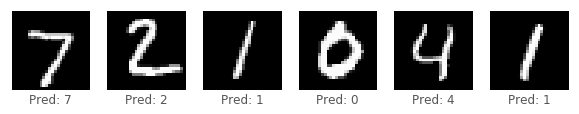

Ideal/Software Based Accuracy: 0.9883
++++++++++++++++++++++++++++++++++++++++


c:\program files\python36\lib\site-packages\ipykernel_launcher.py:402: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:407: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:412: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:417: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:422: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
c:\program files\python36\lib\site-packages\ipykernel_launcher.py:427: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


10000/10000 [==============================] - 9s 866us/step
Evaluation Tool: Un Rectified
Train on 48000 samples, validate on 12000 samples
Epoch 1/1
10000/10000 [==============================] - 7s 695us/step


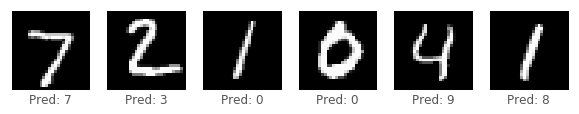

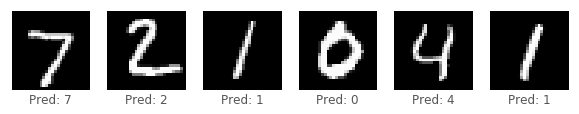

Defect percentage: 4 --> Accuracy:-Un Rectified: 0.5065
Retrained Accuracy:-Un Rectified: 0.9863
____________________________________________________________

10000/10000 [==============================] - 10s 969us/step
Evaluation Tool: Existing Cells
Train on 48000 samples, validate on 12000 samples
Epoch 1/1
10000/10000 [==============================] - 11s 1ms/step


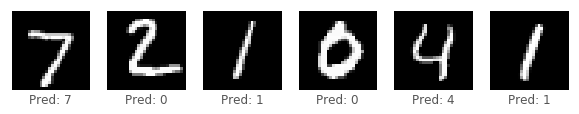

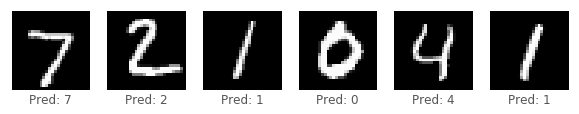

Defect percentage: 4 --> Accuracy:-Existing Cells: 0.85
Retrained Accuracy:-Existing Cells: 0.9865
____________________________________________________________

10000/10000 [==============================] - 10s 985us/step
Evaluation Tool: Redundant Columns
Train on 48000 samples, validate on 12000 samples
Epoch 1/1
10000/10000 [==============================] - 10s 1ms/step


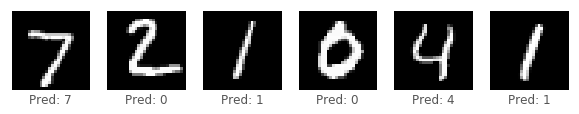

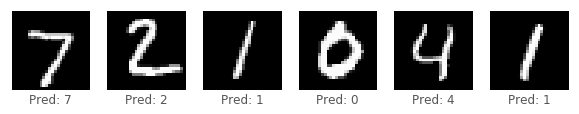

Defect percentage: 4 --> Accuracy:-Redundant Columns: 0.85
Retrained Accuracy:-Redundant Columns: 0.9865
____________________________________________________________

10000/10000 [==============================] - 11s 1ms/step
Evaluation Tool: Existing Cells and Redundant Columns
Train on 48000 samples, validate on 12000 samples
Epoch 1/1
10000/10000 [==============================] - 12s 1ms/step


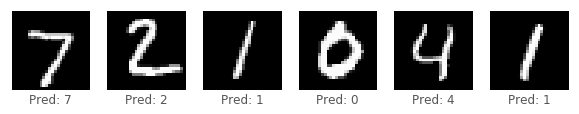

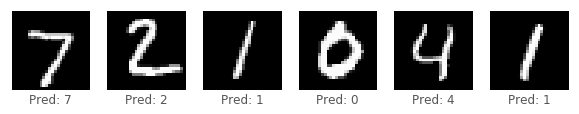

Defect percentage: 4 --> Accuracy:-Existing Cells and Redundant Columns: 0.977
Retrained Accuracy:-Existing Cells and Redundant Columns: 0.99
____________________________________________________________

____________________________________________________________
Defect(%): [array([4])]
acc_or: [0.5065]
Existing Cells: [0.85]
Redundant Cols: [0.85]
acc_mixed: [0.977]
Proposed Or: []
Proposed Rec: []


ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

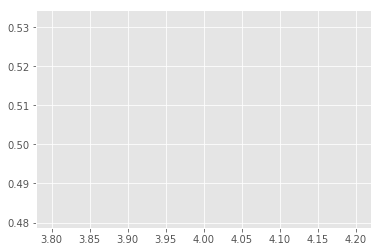

In [22]:
if __name__ == '__main__':
    main()

#### 